In [83]:
import libsumo

PHASES_COUNT = 8
CONFIG_PATH = "../sumo_conf/scenario1/osm.sumocfg"
MIN_TIME = 5
MAX_TIME = 60


class SumoContext:
    def __enter__(self):
        libsumo.start(["sumo", "-c", CONFIG_PATH])
        return libsumo

    def __exit__(self, exc_type, exc_val, exc_tb):
        libsumo.close()


def base_program_logic():
    with SumoContext() as sumo:
        junction_tl_id = sumo.trafficlight_getIDList()[0]
        logic = sumo.trafficlight_getAllProgramLogics(junction_tl_id)[0]
        return junction_tl_id, logic


JUNCTION_TL_ID, LOGIC = base_program_logic()

In [84]:
def fitness(durations: list[int]):
    with SumoContext() as sumo:
        phases = LOGIC.getPhases()
        for i in range(PHASES_COUNT):
            phases[i].duration = float(durations[i])
            phases[i].minDur = float(durations[i])
            phases[i].maxDur = float(durations[i])
        sumo.trafficlight.setProgramLogic(JUNCTION_TL_ID, LOGIC)
        total_wt = 0
        total_veh = 0
        for i in range(3600):
            sumo.simulationStep()
            for veh_id in libsumo.vehicle.getIDList():
                if libsumo.vehicle.getSpeed(veh_id) < 0.1:
                    total_wt += 1
            total_veh += libsumo.simulation.getArrivedNumber()
        return total_wt / total_veh

In [104]:
phases_duration = list(map(lambda x: x.duration, base_program_logic()[1].getPhases()))
default_res = fitness(phases_duration)
print("Default solution: \nX = %s\nF = %s" % (phases_duration, default_res))

Default solution: 
X = [60.0, 5.0, 30.0, 5.0, 60.0, 5.0, 30.0, 5.0]
F = 67.4054747647562


In [86]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.optimize import minimize
from pymoo.core.evaluator import Evaluator
from pymoo.core.population import Population
from random import randint
import numpy as np

class SumoProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=PHASES_COUNT, n_obj=1, xl=np.array([MIN_TIME] * PHASES_COUNT), xu=np.array([MAX_TIME] * PHASES_COUNT))

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = fitness(x)
    
problem = SumoProblem()
pop_size = 30

In [87]:
X = [list(map(lambda x: x.duration + randint(0, 5), base_program_logic()[1].getPhases())) for _ in range(pop_size)]
X = np.array(X)
pop = Population.new("X", X)
Evaluator().eval(problem, pop)

Population([<pymoo.core.individual.Individual object at 0x0000023A0C06DF70>,
           dtype=object)

In [88]:
ga = GA(pop_size=pop_size, eliminate_duplicates=True, sampling=pop)
ga_res = minimize(problem=problem, algorithm=ga, termination=('n_eval', 2500), seed=1, verbose=True)
print("Best solution found for GA: \nX = %s\nF = %s" % (ga_res.X, ga_res.F))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        0 |  7.585486E+01 |  6.706324E+01
     2 |       30 |  7.047963E+01 |  6.635309E+01
     3 |       60 |  6.788797E+01 |  6.331861E+01
     4 |       90 |  6.608131E+01 |  6.207926E+01
     5 |      120 |  6.456849E+01 |  6.180976E+01
     6 |      150 |  6.285667E+01 |  6.168550E+01
     7 |      180 |  6.203030E+01 |  5.845748E+01
     8 |      210 |  6.118506E+01 |  5.775548E+01
     9 |      240 |  5.993686E+01 |  5.649114E+01
    10 |      270 |  5.826660E+01 |  5.607699E+01
    11 |      300 |  5.705442E+01 |  5.475484E+01
    12 |      330 |  5.618348E+01 |  5.475484E+01
    13 |      360 |  5.557542E+01 |  5.423906E+01
    14 |      390 |  5.508789E+01 |  5.369638E+01
    15 |      420 |  5.474839E+01 |  5.218587E+01
    16 |      450 |  5.427210E+01 |  5.104107E+01
    17 |      480 |  5.359982E+01 |  4.991154E+01
    18 |      510 |  5.274228E+01 |  4.932997E+01
    19 |      540 |  5.155262E+01 |  4.928463E+01


In [89]:
de = DE(pop_size=pop_size, sampling=pop)
de_res = minimize(problem=problem, algorithm=de, termination=('n_eval', 2500), seed=1, verbose=True)
print("Best solution found for DE: \nX = %s\nF = %s" % (de_res.X, de_res.F))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        0 |  7.585486E+01 |  6.706324E+01
     2 |       30 |  7.312758E+01 |  6.612870E+01
     3 |       60 |  7.083053E+01 |  6.368027E+01
     4 |       90 |  6.905077E+01 |  6.285025E+01
     5 |      120 |  6.712135E+01 |  6.216203E+01
     6 |      150 |  6.531961E+01 |  6.130000E+01
     7 |      180 |  6.451096E+01 |  6.094576E+01
     8 |      210 |  6.384321E+01 |  6.080876E+01
     9 |      240 |  6.329170E+01 |  6.080876E+01
    10 |      270 |  6.263864E+01 |  6.007855E+01
    11 |      300 |  6.213641E+01 |  5.890360E+01
    12 |      330 |  6.153731E+01 |  5.768098E+01
    13 |      360 |  6.083157E+01 |  5.768098E+01
    14 |      390 |  6.022911E+01 |  5.684104E+01
    15 |      420 |  5.969272E+01 |  5.667035E+01
    16 |      450 |  5.934615E+01 |  5.667035E+01
    17 |      480 |  5.880636E+01 |  5.516822E+01
    18 |      510 |  5.864505E+01 |  5.516822E+01
    19 |      540 |  5.836488E+01 |  5.516822E+01


In [90]:
nel = NelderMead(sampling=pop)
nel_res = minimize(problem=problem, algorithm=nel, termination=('n_eval', 2500), seed=1, verbose=True)
print("Best solution found for NelderMead: \nX = %s\nF = %s" % (nel_res.X, nel_res.F))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        0 |  7.585486E+01 |  6.706324E+01
     2 |        8 |  6.842531E+01 |  6.553441E+01
     3 |       10 |  6.801689E+01 |  6.553441E+01
     4 |       11 |  6.765908E+01 |  6.553441E+01
     5 |       12 |  6.725972E+01 |  6.553441E+01
     6 |       14 |  6.669464E+01 |  6.473957E+01
     7 |       15 |  6.619058E+01 |  6.473957E+01
     8 |       16 |  6.601845E+01 |  6.473957E+01
     9 |       17 |  6.592911E+01 |  6.473957E+01
    10 |       19 |  6.565730E+01 |  6.443111E+01
    11 |       20 |  6.558905E+01 |  6.443111E+01
    12 |       22 |  6.533837E+01 |  6.407919E+01
    13 |       23 |  6.511750E+01 |  6.407919E+01
    14 |       24 |  6.495026E+01 |  6.407919E+01
    15 |       26 |  6.460551E+01 |  6.298816E+01
    16 |       27 |  6.439733E+01 |  6.298816E+01
    17 |       28 |  6.427081E+01 |  6.298816E+01
    18 |       29 |  6.408176E+01 |  6.298816E+01
    19 |       30 |  6.393415E+01 |  6.298816E+01


In [91]:
cmaes = CMAES(pop_size=pop_size)
cmaes_res = minimize(problem=problem, algorithm=cmaes, termination=('n_eval', 2500), seed=1, verbose=True)
print("Best solution found for CMAES: \nX = %s\nF = %s" % (cmaes_res.X, cmaes_res.F))

n_gen  |  n_eval  |     f_avg     |     f_min     |     sigma     | min_std  | max_std  |   axis  
     1 |       20 |  1.802013E+02 |  9.163776E+01 |  0.1000000000 |  0.10000 |  0.10000 |  1.00004
     2 |       50 |  9.351902E+01 |  8.245385E+01 |  0.1077807784 |  0.09977 |  0.11847 |  1.39194
     3 |       80 |  8.994333E+01 |  7.511854E+01 |  0.1304619924 |  0.11841 |  0.15991 |  1.56010
     4 |      110 |  8.544039E+01 |  6.919237E+01 |  0.1622311268 |  0.13961 |  0.20313 |  1.67468
     5 |      140 |  8.112016E+01 |  6.498986E+01 |  0.2248280454 |  0.18691 |  0.28588 |  1.75101
     6 |      170 |  8.365836E+01 |  4.895784E+01 |  0.2989955724 |  0.25147 |  0.35547 |  1.69415
     7 |      200 |  8.910132E+01 |  4.895784E+01 |  0.2761125215 |  0.21957 |  0.30620 |  1.57968
     8 |      230 |  9.921688E+01 |  4.895784E+01 |  0.2699754907 |  0.21317 |  0.28915 |  1.68799
     9 |      260 |  1.008956E+02 |  4.895784E+01 |  0.2653019990 |  0.20664 |  0.27635 |  1.63809
    10 |  

In [92]:
isres = ISRES(pop_size=pop_size, sampling=pop)
isres_res = minimize(problem=problem, algorithm=isres, termination=('n_eval', 2500), seed=1, verbose=True)
print("Best solution found for ISRES: \nX = %s\nF = %s" % (isres_res.X, isres_res.F))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        0 |  7.585486E+01 |  6.706324E+01
     2 |      200 |  6.403986E+01 |  5.488419E+01
     3 |      400 |  6.367120E+01 |  5.078970E+01
     4 |      600 |  6.164670E+01 |  4.387332E+01
     5 |      800 |  5.941047E+01 |  4.387332E+01
     6 |     1000 |  5.697060E+01 |  4.387332E+01
     7 |     1200 |  5.762939E+01 |  4.116933E+01
     8 |     1400 |  5.758956E+01 |  4.116933E+01
     9 |     1600 |  5.494866E+01 |  3.853523E+01
    10 |     1800 |  5.716166E+01 |  3.853523E+01
    11 |     2000 |  5.309544E+01 |  3.853523E+01
    12 |     2200 |  5.177316E+01 |  3.853523E+01
    13 |     2400 |  5.172679E+01 |  3.853523E+01
    14 |     2600 |  5.043516E+01 |  3.853523E+01
Best solution found for ISRES: 
X = [17.38830198  5.07950884 34.40154019  5.86481592 14.80184477 14.56523576
 10.58238395  8.71999104]
F = [38.5352349]


<BarContainer object of 6 artists>

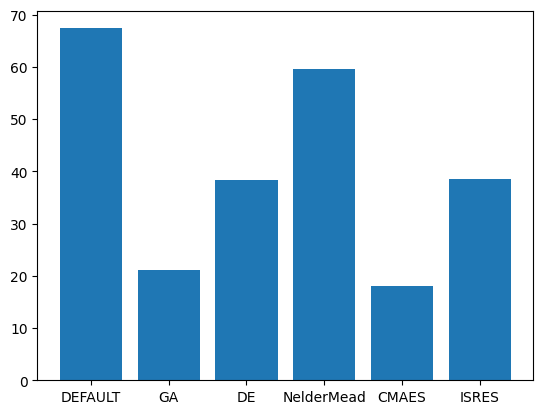

In [105]:
# make a diagram comparing all the algorithms results
import matplotlib.pyplot as plt

x = ['DEFAULT', 'GA', 'DE', 'NelderMead', 'CMAES', 'ISRES']
y = [default_res, ga_res.F[0], de_res.F[0], nel_res.F[0], cmaes_res.F[0], isres_res.F[0]]
plt.bar(x, y)